In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.dummy import DummyClassifier


In [17]:

def load_data(path):
    df = pd.read_csv(path,sep=',', comment='#', header=None)
    x1=df.iloc[:,0]
    x2=df.iloc[:,1]
    x=np.column_stack((x1,x2))
    y=df.iloc[:,2]
    return x, y

# (a) determine best poly degree and c value of penalty of Logistic regression
def FindBestPolyDegree(x, y, poly_range):
    poly = PolynomialFeatures()
    best_degree = 1
    best_penalty = 0
    best_acuracy = 0
    accuracy_mean_error=[]
    accuracy_std_error=[]
    for p in poly_range:
        # polynomial transformation
        poly.set_params(degree=p)
        x_poly = poly.fit_transform(x)


        model = LogisticRegression("l2")

        # cross validation with 5 folds
        scores = cross_val_score(model, x_poly, y, cv = 5, scoring='f1')
        mean = np.mean(scores)
        accuracy_mean_error.append(mean)
        accuracy_std_error.append(np.std(scores))
        
        if(mean > best_acuracy):
            best_acuracy = np.mean(scores)
            best_degree = p
    
    plt.errorbar(poly_range, accuracy_mean_error, yerr=accuracy_std_error, label='Accuracy error bars') 

    print(f"Maximum accuracy: {best_acuracy:.4f} at degree {best_degree}")
    plt.xlabel('Polynomial Degree') 
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right', fontsize = 10)
    plt.show()
    return best_degree

def FindBestC(x, y, best_degree, c_range):
    
    poly = PolynomialFeatures(best_degree)
    x_poly = poly.fit_transform(x)

    accuracy_mean_error=[]
    accuracy_std_error=[]
    best_penalty = 0
    best_acuracy = 0
    for c in c_range:
        model = LogisticRegression("l2", C=c)

        # cross validation with 5 folds
        scores = cross_val_score(model, x_poly, y, cv = 5, scoring='f1')
        mean = np.mean(scores)
        accuracy_mean_error.append(mean)
        accuracy_std_error.append(np.std(scores))
        
        if(mean > best_acuracy):
            best_acuracy = np.mean(scores)
            best_penalty = c

    plt.errorbar(c_range, accuracy_mean_error, yerr=accuracy_std_error, linewidth=3, label='F1 error bars') 

    print(f"Maximum accuracy: {best_acuracy:.4f} at degree {best_degree} with C {best_penalty:.4f}")
    plt.xlabel('C') 
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right', fontsize = 10)
    plt.show()
    return best_penalty

# draw the best model predictions
def DrawBestLogisticPredictions(x, y, best_degree, best_penalty):
    poly = PolynomialFeatures()
    poly.set_params(degree=best_degree)
    x_poly = poly.fit_transform(x)

    x_poly_train, x_poly_test, y_poly_train, y_poly_test = train_test_split(x_poly, y, test_size=0.2, random_state=1)

    plt.scatter(x_poly_train[y_poly_train == 1][:, 1],  x_poly_train[y_poly_train == 1][:, 2],  color='#00ff00', marker='+', label='+1 Data')
    plt.scatter(x_poly_train[y_poly_train == -1][:, 1], x_poly_train[y_poly_train == -1][:, 2], color='#0000fd', marker='o', label='-1 Data')

    best_logistic = LogisticRegression("l2", C=best_penalty)
    best_logistic.fit(x_poly_train, y_poly_train)
    y_best_logistic_pred = best_logistic.predict(x_poly_test)


    plt.scatter(x_poly_test[y_best_logistic_pred == 1][:, 1],  x_poly_test[y_best_logistic_pred == 1][:, 2],  color="red", marker='^', label='+1 Prediction')
    plt.scatter(x_poly_test[y_best_logistic_pred == -1][:, 1], x_poly_test[y_best_logistic_pred == -1][:, 2], color="orange", marker='v', label='-1 Prediction')

    # print(f"F1: {best_logistic.(x_poly_test, y_poly_test):.4f}")

    plt.rc('font', size=18)
    plt.xlabel('X_1'); plt.ylabel('X_2')
    plt.legend(loc='upper right', fontsize = 10)
    plt.show()
    return best_logistic, y_best_logistic_pred, x_poly_test, y_poly_test

# (b) determine best k value of KNN
def FindBestKForKNN(x, y, k_range):
    best_k = 1
    best_acuracy = 0
    accuracy_mean_error=[]
    accuracy_std_error=[]
    for k in k_range:
        model = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(model, x, y, cv = 5, scoring='f1')
        mean = np.mean(scores)
        if(mean > best_acuracy):
            best_acuracy = mean
            best_k = k
        accuracy_mean_error.append(mean)
        accuracy_std_error.append(np.std(scores))

    plt.errorbar(k_range, accuracy_mean_error, yerr=accuracy_std_error, linewidth=3, label='F1 error bars')
    plt.xlabel('K')
    plt.ylabel('F1 Score')
    plt.legend(loc='best', fontsize = 10)
    plt.show()
    print(f"Maximum F1: {best_acuracy:.4f} at k={best_k}")
    return best_k

def DrawBestKNNPrediction(x, y, best_k):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    plt.scatter(x_train[y_train == 1][:, 0],  x_train[y_train == 1][:, 1],  color='#00ff00', marker='+', label='+1 Data')
    plt.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='#0000fd', marker='o', label='-1 Data')

    best_kNN = KNeighborsClassifier(n_neighbors=best_k)
    best_kNN.fit(x_train, y_train)
    y_best_kNN_pred = best_kNN.predict(x_test)

    plt.scatter(x_test[y_best_kNN_pred == 1][:, 0],  x_test[y_best_kNN_pred == 1][:, 1],  color="red", marker='^', label='+1 Prediction')
    plt.scatter(x_test[y_best_kNN_pred == -1][:, 0], x_test[y_best_kNN_pred == -1][:, 1], color="orange", marker='v', label='-1 Prediction')
    plt.legend(loc='upper right', fontsize = 10)
    plt.show()
    print(f"F1: {best_kNN.score(x_test, y_test):.4f}")
    return best_kNN, y_best_kNN_pred

# (c) confusion matrices
import seaborn as sns
def ConfutionMatrix(x, y, y_best_logistic_pred, y_best_kNN_pred):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    def plot_confusion_matrix(x_loc, y_loc, y_test, y_pred, title):
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
                    xticklabels=["Predicted -1", "Predicted +1"], 
                    yticklabels=["Actual -1", "Actual +1"], ax=axes[x_loc, y_loc])
        axes[x_loc, y_loc].set_yticklabels(axes[x_loc, y_loc].get_yticklabels(), rotation=90)
        axes[x_loc, y_loc].set_title(title)

        tn, fp, fn, tp = conf_matrix.ravel()

        # Calculate recall (sensitivity)
        recall = tp / (tp + fn)

        # Calculate specificity
        specificity = tn / (tn + fp)

        # Calculate precision
        precision = tp / (tp + fp)

        # Calculate F1 score
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Display the results
        print(f"Recall (Sensitivity): {recall:.2f}")
        print(f"Specificity: {specificity:.2f}")
        print(f"F1 Score: {f1_score:.2f}")    


    print("Most Frequent Dummy Classifier Confution Matrix")
    most_frequent_dummy = DummyClassifier(strategy='most_frequent').fit(x_train, y_train)
    ydummy = most_frequent_dummy.predict(x_test)
    plot_confusion_matrix(0, 0, y_test, ydummy, "Most Frequent Dummy Classifier")

    print("Random Dummy Classifier Confution Matrix")
    random_dummy = DummyClassifier(strategy='uniform', random_state=42).fit(x_train, y_train)
    ydummy = random_dummy.predict(x_test)
    plot_confusion_matrix(0, 1, y_test, ydummy, "Random Dummy Classifier")


    print("Logistic Regression Confution Matrix")
    plot_confusion_matrix(1, 0, y_test, y_best_logistic_pred, "Logistic Regression")
    
    print("KNN Confution Matrix")
    plot_confusion_matrix(1, 1, y_test, y_best_kNN_pred, "KNN")

    plt.subplots_adjust(wspace=0.4, hspace=0.25)  # Increase space between plots
    plt.show()

    return most_frequent_dummy, random_dummy

# (d) ROC curve
def DrawROCCurve(x, y, x_poly_test, y_poly_test, best_logistic, best_kNN, most_frequent_dummy, random_dummy):
    fpr, tpr, thresholds = roc_curve(y_poly_test, best_logistic.decision_function(x_poly_test))
    plt.plot(fpr, tpr, label='Logistic Regression')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
    fpr, tpr, thresholds = roc_curve(y_test, best_kNN.predict_proba(x_test)[:,1])
    plt.plot(fpr, tpr, label='KNN')
    fpr, tpr, thresholds = roc_curve(y_test, most_frequent_dummy.predict_proba(x_test)[:,1])
    plt.plot(fpr, tpr, label='Most Frequent Dummy')
    fpr, tpr, thresholds = roc_curve(y_test, random_dummy.predict_proba(x_test)[:,1])
    plt.plot(fpr, tpr, label='Random Dummy')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fontsize = 10)
    plt.show()
    print("Logistic Regression AUC: ", roc_auc_score(y_poly_test, best_logistic.decision_function(x_poly_test)))
    print("KNN AUC: ", roc_auc_score(y_test, best_kNN.predict_proba(x_test)[:,1]))
    print("Most Frequent Dummy AUC: ", roc_auc_score(y_test, most_frequent_dummy.predict_proba(x_test)[:,1]))
    print("Random Dummy AUC: ", roc_auc_score(y_test, random_dummy.predict_proba(x_test)[:,1]))
          

Running on week4_1.csv:


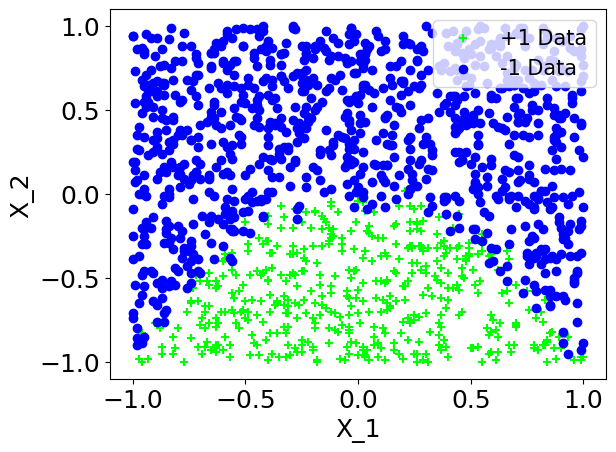

Maximum accuracy: 0.9442 at degree 2


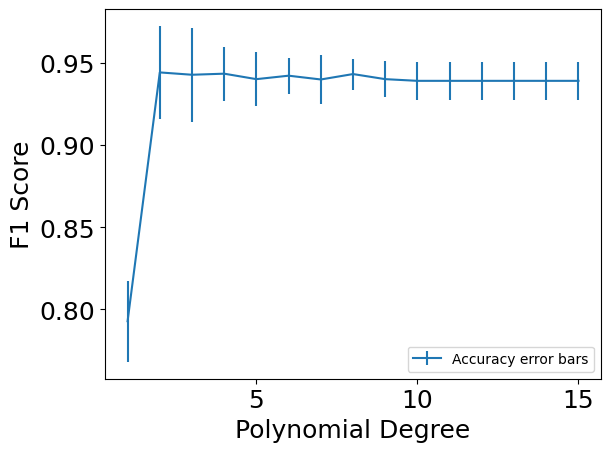

Maximum accuracy: 0.9516 at degree 2 with C 69.1238


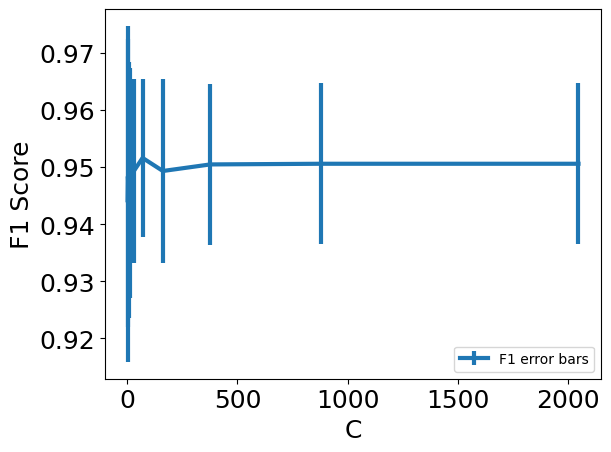

Maximum accuracy: 0.9516 at degree 2 with C 57.3653


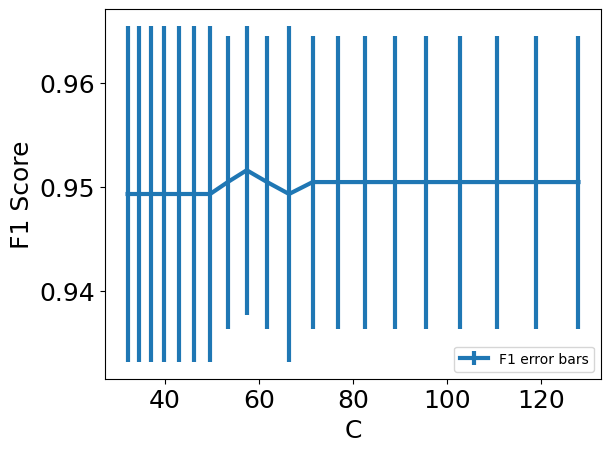

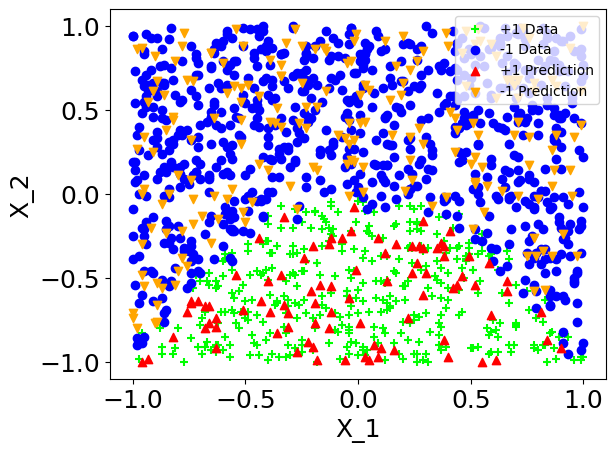

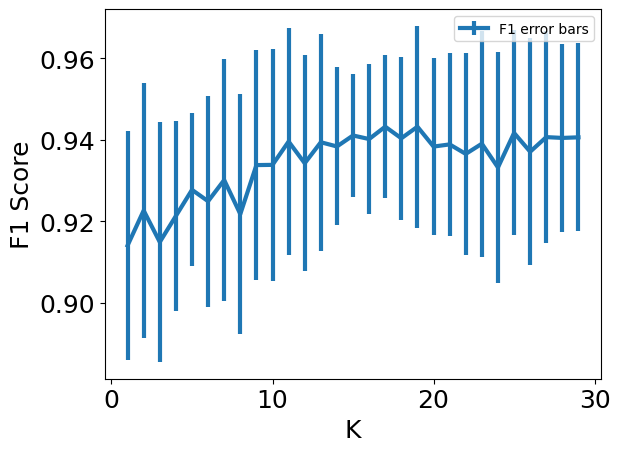

Maximum F1: 0.9432 at k=17


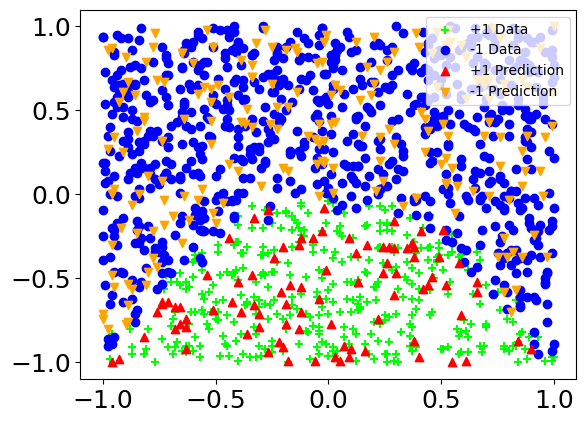

F1: 0.9611
Most Frequent Dummy Classifier Confution Matrix
Recall (Sensitivity): 0.00
Specificity: 1.00
F1 Score: nan
Random Dummy Classifier Confution Matrix
Recall (Sensitivity): 0.53
Specificity: 0.51
F1 Score: 0.41
Logistic Regression Confution Matrix
Recall (Sensitivity): 0.95
Specificity: 0.98
F1 Score: 0.95
KNN Confution Matrix
Recall (Sensitivity): 0.94
Specificity: 0.97
F1 Score: 0.94


C:\Users\sky\AppData\Local\Temp\ipykernel_29520\2083148382.py:166: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


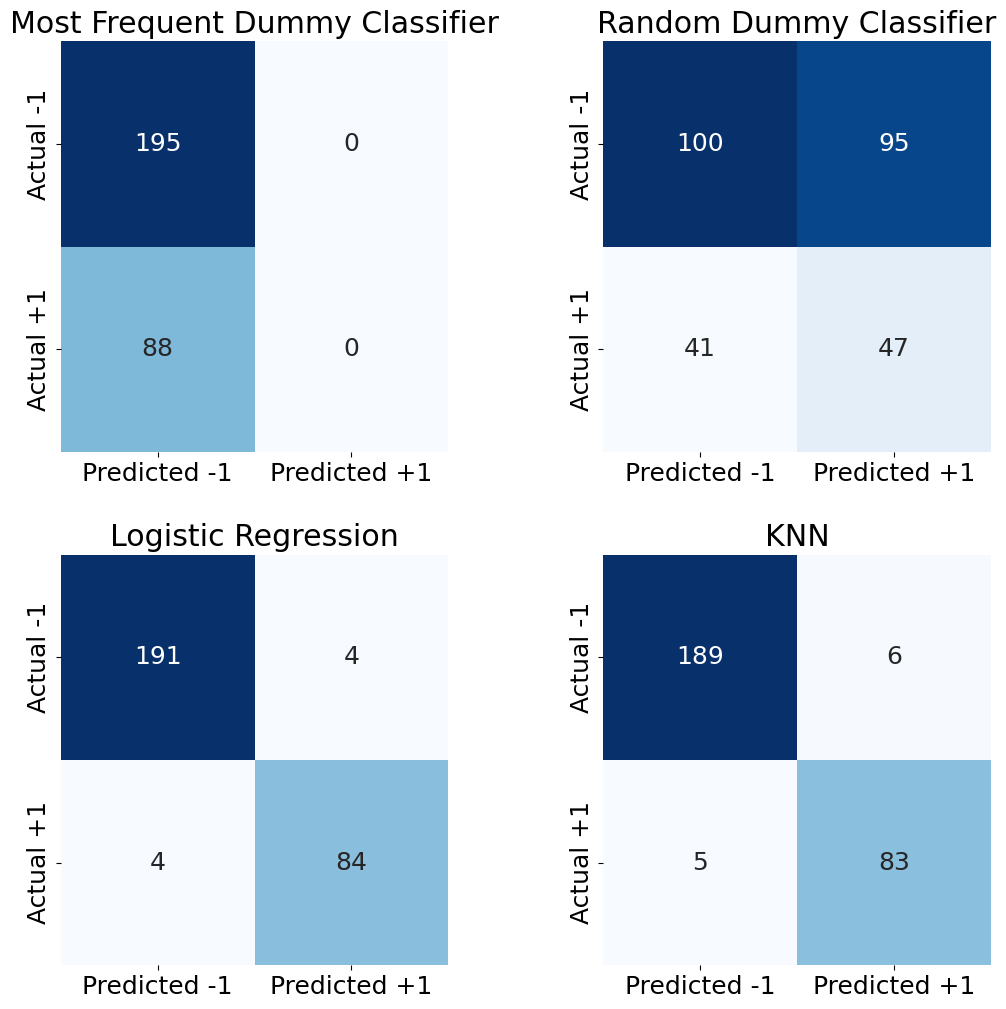

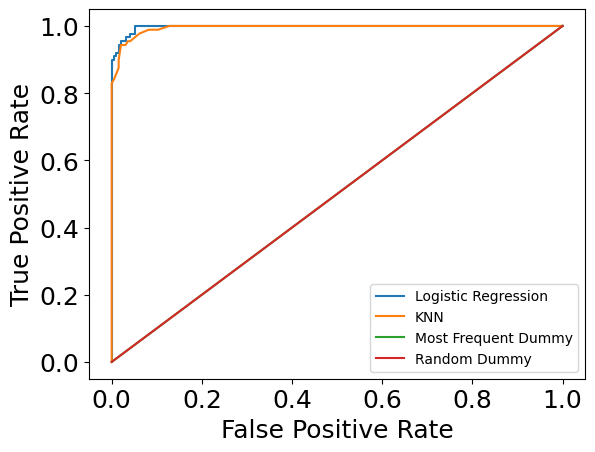

Logistic Regression AUC:  0.9972610722610722
KNN AUC:  0.9947843822843823
Most Frequent Dummy AUC:  0.5
Random Dummy AUC:  0.5


In [19]:
# (i) data set week4_1.csv
print("Running on week4_1.csv:")
x, y = load_data('week4_1.csv')

plt.scatter(x[y == 1][:, 0],  x[y == 1][:, 1],  color='#00ff00', marker='+', label='+1 Data')
plt.scatter(x[y == -1][:, 0], x[y == -1][:, 1], color='#0000fd', marker='o', label='-1 Data')
plt.xlabel('X_1'); plt.ylabel('X_2')
plt.legend(loc='upper right', fontsize = 15)
plt.show()

# try polynomial degree from 1 to 9
best_degree = FindBestPolyDegree(x, y, range(1, 16))

# try C of penalty from 1 to 1000
best_penalty = FindBestC(x, y, best_degree, np.logspace(0, 11, 20, base=2))

# try C of penalty from 1 to 1000
best_penalty = FindBestC(x, y, best_degree, np.logspace(5, 7, 20, base=2))

best_logistic, y_best_logistic_pred, x_poly_test, y_poly_test = DrawBestLogisticPredictions(x, y, best_degree, best_penalty)

best_k = FindBestKForKNN(x, y, range(1, 30))
best_kNN, y_best_kNN_pred = DrawBestKNNPrediction(x, y, best_k)
most_frequent_dummy, random_dummy = ConfutionMatrix(x, y, y_best_logistic_pred, y_best_kNN_pred)
DrawROCCurve(x, y, x_poly_test, y_poly_test, best_logistic, best_kNN, most_frequent_dummy, random_dummy)

Running on week4_2.csv


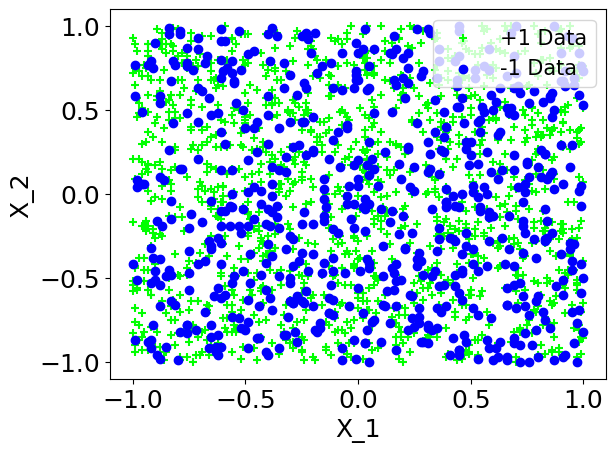

Maximum accuracy: 0.8032 at degree 1


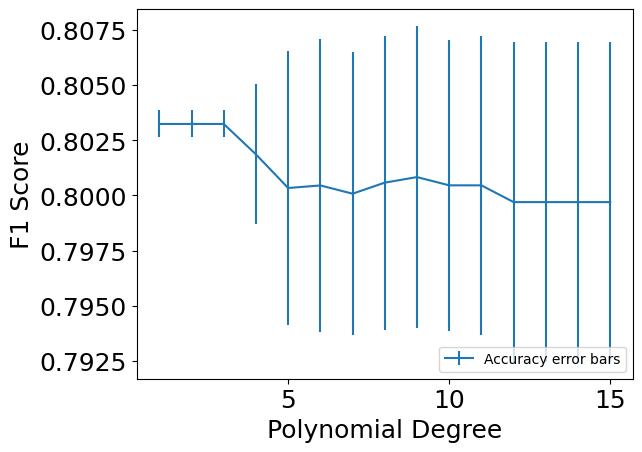

Maximum accuracy: 0.8032 at degree 1 with C 0.0312


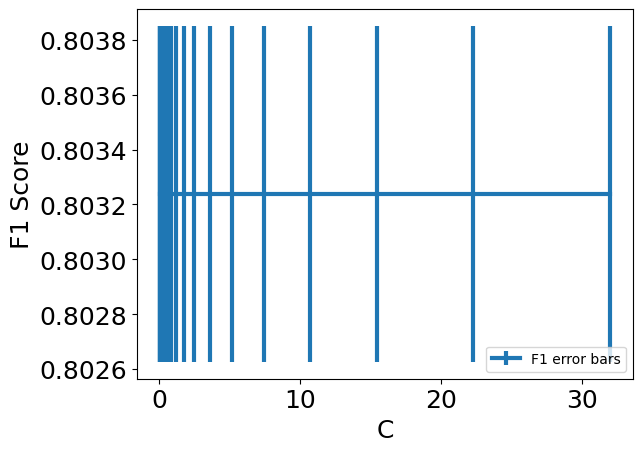

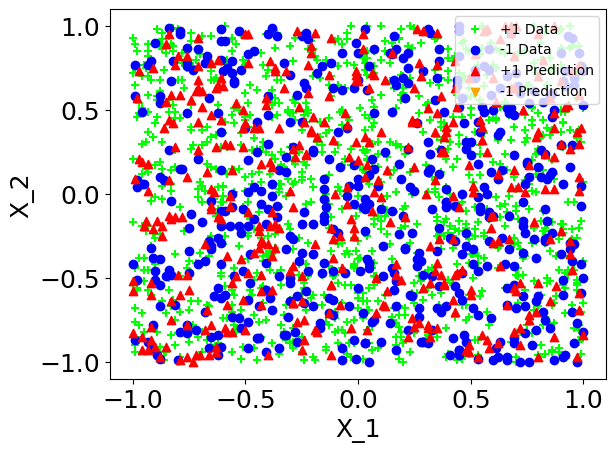

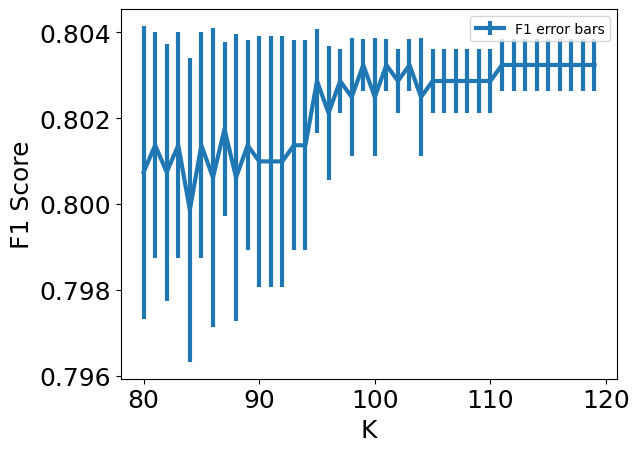

Maximum F1: 0.8032 at k=99


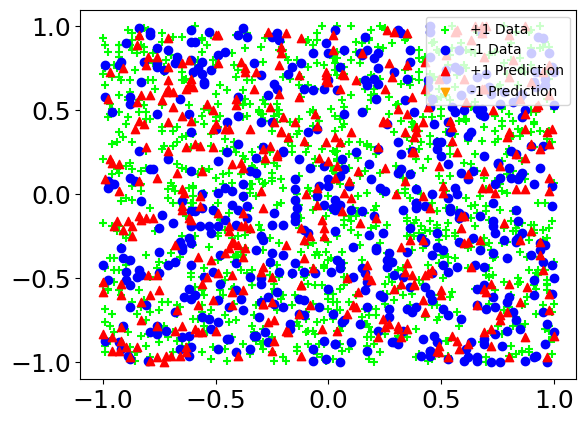

F1: 0.6649
Most Frequent Dummy Classifier Confution Matrix
Recall (Sensitivity): 1.00
Specificity: 0.00
F1 Score: 0.80
Random Dummy Classifier Confution Matrix
Recall (Sensitivity): 0.49
Specificity: 0.47
F1 Score: 0.56
Logistic Regression Confution Matrix
Recall (Sensitivity): 1.00
Specificity: 0.00
F1 Score: 0.80
KNN Confution Matrix
Recall (Sensitivity): 1.00
Specificity: 0.00
F1 Score: 0.80


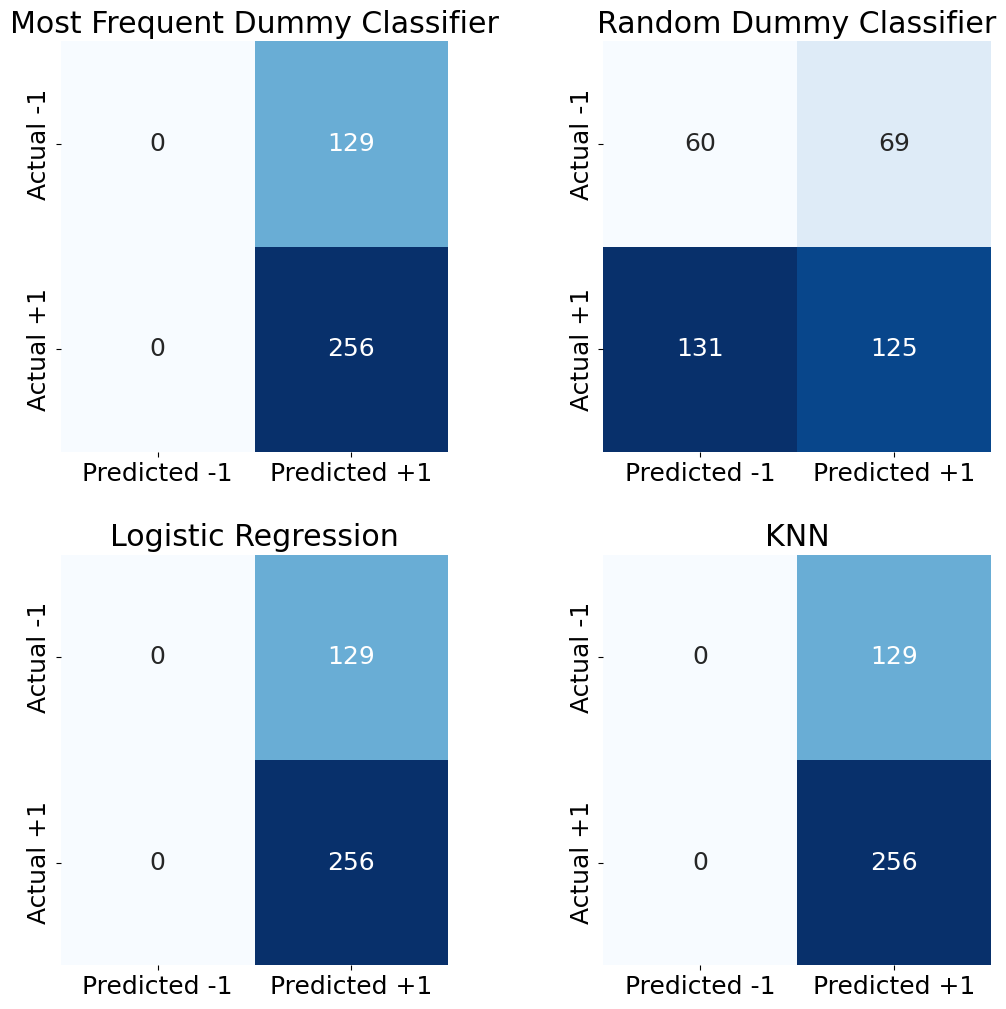

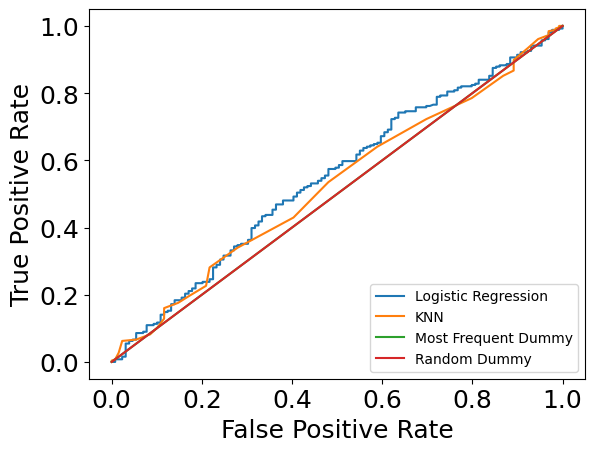

Logistic Regression AUC:  0.5486767199612403
KNN AUC:  0.5265867248062016
Most Frequent Dummy AUC:  0.5
Random Dummy AUC:  0.5


In [20]:
# (ii)
print("Running on week4_2.csv")
x, y = load_data('week4_2.csv')

plt.scatter(x[y == 1][:, 0],  x[y == 1][:, 1],  color='#00ff00', marker='+', label='+1 Data')
plt.scatter(x[y == -1][:, 0], x[y == -1][:, 1], color='#0000fd', marker='o', label='-1 Data')
plt.xlabel('X_1'); plt.ylabel('X_2')
plt.legend(loc='upper right', fontsize = 15)
plt.show()

best_degree = FindBestPolyDegree(x, y, range(1, 16))
best_penalty = FindBestC(x, y, best_degree, np.logspace(-5, 5, 20, base=2))
best_logistic, y_best_logistic_pred, x_poly_test, y_poly_test = DrawBestLogisticPredictions(x, y, best_degree, best_penalty)
best_k = FindBestKForKNN(x, y,  range(80, 120))
best_kNN, y_best_kNN_pred = DrawBestKNNPrediction(x, y, best_k)
most_frequent_dummy, random_dummy = ConfutionMatrix(x, y, y_best_logistic_pred, y_best_kNN_pred)
DrawROCCurve(x, y, x_poly_test, y_poly_test, best_logistic, best_kNN, most_frequent_dummy, random_dummy)

